# Comparing two descriptors: SIFT, AKAZE

In [1]:
import cv2 
import matplotlib.pyplot as plt
import numpy as np
import os
from os import listdir
from os.path import isfile, join
from json import dump
import time
import pandas as pd
%matplotlib inline

In [2]:
def umat_to_mat(obj):
    return cv2.UMat.get(obj)

In [9]:
def get_metrics(path_directory, image_name, descriptor, keypoints_image_kernel, descriptors_image_kernel, 
                matcher, image_kernel, ratio=0.75):
    
    image_path = f'{path_directory}/{image_name}'
    
    print(image_path)
    metrics = {'ratio':ratio}
    
    # define start time
    time_start = time.thread_time()
    
    image = cv2.imread(image_path)
    metrics['pixels'] = image.shape[0] * image.shape[1]
    image = cv2.UMat(image)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    keypoints_image, descriptors_image = descriptor.detectAndCompute(gray,None)
        
    image_features = cv2.drawKeypoints(umat_to_mat(gray),keypoints_image,umat_to_mat(image_kernel))

    # find matches
    # print(f'type (descriptors_image_kernel) : {type(descriptors_image_kernel)}\n type (descriptors_image): {type(descriptors_image)}')
    matches = matcher.knnMatch(descriptors_image_kernel, descriptors_image, k=2) # sift k = 2
    
    # define end time
    time_end = time.thread_time()
    metrics['thread_time'] = time_end - time_start
    
    # compute distance
    good_matches = []
    for m, n in matches:
        if m.distance < ratio * n.distance:
            good_matches.append(m)
    
    image_maches_draw = cv2.drawMatches(image_kernel, keypoints_image_kernel, image, keypoints_image, good_matches, None)
    
    metrics['matches_good_ratio'] = len(good_matches) / np.array(matches)[:,1].shape[0]
    
    localization_errors_l1 = np.array([abs(m.distance - n.distance) for m, n in matches])
    localization_errors_l2 = np.array([np.power(m.distance - n.distance, 2) for m, n in matches])
    
    metrics['localization_error_l1_mean'] = localization_errors_l1.mean()
    metrics['localization_error_l2_mean'] = localization_errors_l2.mean()

    
    #-- Localize the object
#     obj = np.empty((len(good_matches),2), dtype=np.float32)
#     scene = np.empty((len(good_matches),2), dtype=np.float32)

#     for i in range(len(good_matches)):
#         #-- Get the keypoints from the good matches
#         obj[i,0] = keypoints_image_kernel[good_matches[i].queryIdx].pt[0]
#         obj[i,1] = keypoints_image_kernel[good_matches[i].queryIdx].pt[1]
#         scene[i,0] = keypoints_image[good_matches[i].trainIdx].pt[0]
#         scene[i,1] = keypoints_image[good_matches[i].trainIdx].pt[1]
    
#     H, _ =  cv2.findHomography(obj, scene, cv2.RANSAC)
    
#     # print(type(H))
#     if H is None :
#         metrics['loc_error_norm_of_homography_matrix'] = 0
#     else:
#         metrics['loc_error_norm_of_homography_matrix'] = np.linalg.norm(H)
    
    return metrics, image_features, umat_to_mat(image_maches_draw)

In [7]:
def define_metrics(descriptor_name, directory_train_name, json_dump_name, name_directory_dump, ratio=0.75, saved_dump=True):
    '''
    descriptor_name - SIFT, AKAZE string format,
    directory_train_name - string format name of directory,
    json_dump_name - string format name of json_dump
    '''
    metrics_images = {}

    
    path_directory = os.path.abspath(os.getcwd())
    path_directory_image = f'{path_directory}/{directory_train_name}'
    
    path_features = f'{directory_train_name}_{descriptor_name}'
    path_features_compared = f'{directory_train_name}_{descriptor_name}_compared'
    try:
        os.mkdir(path_features)
        os.mkdir(path_features_compared)
        os.mkdir(name_directory_dump)
        
    except FileExistsError:
            pass
    
    all_training_set = np.array([f for f in listdir(path_directory_image) if isfile(join(path_directory_image, f))])
    all_training_set = np.sort(all_training_set)
    
    
    path_kernel_image = f'{path_directory_image}/{all_training_set[1]}'
    
    print(f'kernel : {path_kernel_image}')
    image_kernel = cv2.imread(path_kernel_image) 
    
    # Turn on GPU
    image_kernel = cv2.UMat(image_kernel)
    
    gray_image_kernel = cv2.cvtColor(image_kernel, cv2.COLOR_BGR2GRAY)
        
    if descriptor_name == 'sift':
        print('sift')
        descriptor = cv2.xfeatures2d.SIFT_create()
        matcher = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
        
    elif descriptor_name == 'akaze':
        print('akaze')
        descriptor = cv2.AKAZE_create()
        matcher = cv2.DescriptorMatcher_create(cv2.DescriptorMatcher_BRUTEFORCE_HAMMING)

    else:
        pass
    
    keypoints_image_kernel, descriptors_image_kernel = descriptor.detectAndCompute(gray_image_kernel,None)
    
    for image_file_name in all_training_set[2:]:

        metrics, image_features, image_maches_draw  = get_metrics(path_directory_image, image_file_name, descriptor, keypoints_image_kernel, descriptors_image_kernel,
                              matcher, image_kernel, ratio)
        metrics_images[image_file_name] = metrics
        
        cv2.imwrite(f'{path_features}/{image_file_name}', image_features)
        cv2.imwrite(f'{path_features_compared}/{image_file_name}', image_maches_draw)

    
    if saved_dump:
        with open(f'{name_directory_dump}/{json_dump_name}.json', 'w') as f:
            dump(metrics_images, f, indent=4)
    
    return metrics_images

In [8]:
descriptor_name='sift'
directory_train_name='training_lintroller'
json_dump_name='lintroller_sift'
name_directory_dump = 'lintroller_train_dump'

define_metrics(descriptor_name, directory_train_name, json_dump_name, name_directory_dump)

kernel : /home/eduard/gitRepo/object_recognition/Lab2/training_lintroller/lintroller_1.jpg
sift
/home/eduard/gitRepo/object_recognition/Lab2/training_lintroller/lintroller_10.jpg
type (descriptors_image_kernel) : <class 'cv2.UMat'>
 type (descriptors_image): <class 'cv2.UMat'>
/home/eduard/gitRepo/object_recognition/Lab2/training_lintroller/lintroller_11.jpg
type (descriptors_image_kernel) : <class 'cv2.UMat'>
 type (descriptors_image): <class 'cv2.UMat'>
/home/eduard/gitRepo/object_recognition/Lab2/training_lintroller/lintroller_12.jpg
type (descriptors_image_kernel) : <class 'cv2.UMat'>
 type (descriptors_image): <class 'cv2.UMat'>
/home/eduard/gitRepo/object_recognition/Lab2/training_lintroller/lintroller_13.jpg
type (descriptors_image_kernel) : <class 'cv2.UMat'>
 type (descriptors_image): <class 'cv2.UMat'>
/home/eduard/gitRepo/object_recognition/Lab2/training_lintroller/lintroller_14.jpg
type (descriptors_image_kernel) : <class 'cv2.UMat'>
 type (descriptors_image): <class 'cv2.U

/home/eduard/gitRepo/object_recognition/Lab2/training_lintroller/lintroller_51.jpg
type (descriptors_image_kernel) : <class 'cv2.UMat'>
 type (descriptors_image): <class 'cv2.UMat'>
/home/eduard/gitRepo/object_recognition/Lab2/training_lintroller/lintroller_52.jpg
type (descriptors_image_kernel) : <class 'cv2.UMat'>
 type (descriptors_image): <class 'cv2.UMat'>
/home/eduard/gitRepo/object_recognition/Lab2/training_lintroller/lintroller_53.jpg
type (descriptors_image_kernel) : <class 'cv2.UMat'>
 type (descriptors_image): <class 'cv2.UMat'>
/home/eduard/gitRepo/object_recognition/Lab2/training_lintroller/lintroller_54.jpg
type (descriptors_image_kernel) : <class 'cv2.UMat'>
 type (descriptors_image): <class 'cv2.UMat'>
/home/eduard/gitRepo/object_recognition/Lab2/training_lintroller/lintroller_55.jpg
type (descriptors_image_kernel) : <class 'cv2.UMat'>
 type (descriptors_image): <class 'cv2.UMat'>
/home/eduard/gitRepo/object_recognition/Lab2/training_lintroller/lintroller_56.jpg
type (d

{'lintroller_10.jpg': {'ratio': 0.75,
  'pixels': 76800,
  'thread_time': 0.031052672000000392,
  'matches_good_ratio': 0.026172300981461286,
  'localization_error_l1_mean': 20.671101652288904,
  'localization_error_l2_mean': 840.2126723362895},
 'lintroller_11.jpg': {'ratio': 0.75,
  'pixels': 76800,
  'thread_time': 0.029921258999999978,
  'matches_good_ratio': 0.021810250817884406,
  'localization_error_l1_mean': 20.41917466857311,
  'localization_error_l2_mean': 812.9057805087908},
 'lintroller_12.jpg': {'ratio': 0.75,
  'pixels': 76800,
  'thread_time': 0.03031752600000015,
  'matches_good_ratio': 0.013086150490730643,
  'localization_error_l1_mean': 19.118886234196086,
  'localization_error_l2_mean': 686.0757817666786},
 'lintroller_13.jpg': {'ratio': 0.75,
  'pixels': 62458,
  'thread_time': 0.026916015000000293,
  'matches_good_ratio': 0.003271537622682661,
  'localization_error_l1_mean': 17.50192064391358,
  'localization_error_l2_mean': 569.0753924972042},
 'lintroller_14.jpg

In [10]:
descriptor_name='akaze'
directory_train_name='training_lintroller'
json_dump_name='lintroller_akaze'
name_directory_dump = 'lintroller_train_dump'

define_metrics(descriptor_name, directory_train_name, json_dump_name, name_directory_dump)

kernel : /home/eduard/gitRepo/object_recognition/Lab2/training_lintroller/lintroller_1.jpg
akaze
/home/eduard/gitRepo/object_recognition/Lab2/training_lintroller/lintroller_10.jpg
/home/eduard/gitRepo/object_recognition/Lab2/training_lintroller/lintroller_11.jpg
/home/eduard/gitRepo/object_recognition/Lab2/training_lintroller/lintroller_12.jpg
/home/eduard/gitRepo/object_recognition/Lab2/training_lintroller/lintroller_13.jpg
/home/eduard/gitRepo/object_recognition/Lab2/training_lintroller/lintroller_14.jpg
/home/eduard/gitRepo/object_recognition/Lab2/training_lintroller/lintroller_15.jpg
/home/eduard/gitRepo/object_recognition/Lab2/training_lintroller/lintroller_16.jpg
/home/eduard/gitRepo/object_recognition/Lab2/training_lintroller/lintroller_17.jpg
/home/eduard/gitRepo/object_recognition/Lab2/training_lintroller/lintroller_18.jpg
/home/eduard/gitRepo/object_recognition/Lab2/training_lintroller/lintroller_19.jpg
/home/eduard/gitRepo/object_recognition/Lab2/training_lintroller/lintroll

{'lintroller_10.jpg': {'ratio': 0.75,
  'pixels': 76800,
  'thread_time': 0.029828291000001173,
  'matches_good_ratio': 0.00909090909090909,
  'localization_error_l1_mean': 8.745454545454546,
  'localization_error_l2_mean': 128.4848484848485},
 'lintroller_11.jpg': {'ratio': 0.75,
  'pixels': 76800,
  'thread_time': 0.029991807000001813,
  'matches_good_ratio': 0.012121212121212121,
  'localization_error_l1_mean': 8.43030303030303,
  'localization_error_l2_mean': 129.93939393939394},
 'lintroller_12.jpg': {'ratio': 0.75,
  'pixels': 76800,
  'thread_time': 0.029607978000001367,
  'matches_good_ratio': 0.030303030303030304,
  'localization_error_l1_mean': 8.875757575757575,
  'localization_error_l2_mean': 152.29393939393938},
 'lintroller_13.jpg': {'ratio': 0.75,
  'pixels': 62458,
  'thread_time': 0.0283949640000003,
  'matches_good_ratio': 0.0030303030303030303,
  'localization_error_l1_mean': 8.93030303030303,
  'localization_error_l2_mean': 145.53030303030303},
 'lintroller_14.jpg':

# Working with metrics FOR FIRST OBJECT

In [123]:
file_name_json_sift = 'sandglass_train_dump/sandglass_sift.json'
file_name_json_akaze = 'sandglass_train_dump/sandglass_akaze.json'
metrices_sift = pd.read_json(file_name_json_sift)
metrices_akaze = pd.read_json(file_name_json_akaze)

metrices_sift = metrices_sift.T
metrices_akaze = metrices_akaze.T

In [124]:
metrices_sift

,ratio,pixels,thread_time,matches_good_ratio,localization_error_l1_mean,localization_error_l2_mean
sandglass_10.jpg,0.75,16064064.0,2.539986,0.058947,19.538328,894.555670
sandglass_11.jpg,0.75,16064064.0,2.499736,0.050526,19.046144,862.551798
sandglass_12.jpg,0.75,16064064.0,2.556158,0.044211,20.093924,952.941646
sandglass_13.jpg,0.75,16064064.0,2.505316,0.103158,31.221451,1721.215351
sandglass_14.jpg,0.75,16064064.0,2.557816,0.216842,45.377040,3921.980997
...,...,...,...,...,...,...
sandglass_78.jpg,0.75,16064064.0,2.716929,0.037895,15.655334,582.194956
sandglass_79.jpg,0.75,16064064.0,2.687720,0.014737,13.742951,366.028911
sandglass_8.jpg,0.75,16064064.0,2.535141,0.037895,25.720951,1306.531401
sandglass_80.jpg,0.75,15996752.0,2.536738,0.025263,23.615181,1046.782228


In [125]:
metrices_akaze

,ratio,pixels,thread_time,matches_good_ratio,localization_error_l1_mean,localization_error_l2_mean
sandglass_10.jpg,0.75,16064064.0,1.481582,0.076744,8.851163,154.525581
sandglass_11.jpg,0.75,16064064.0,1.474736,0.074419,9.195349,163.679070
sandglass_12.jpg,0.75,16064064.0,1.452708,0.037209,7.869767,134.772093
sandglass_13.jpg,0.75,16064064.0,1.477214,0.027907,7.279070,103.190698
sandglass_14.jpg,0.75,16064064.0,1.497960,0.037209,8.344186,138.400000
...,...,...,...,...,...,...
sandglass_78.jpg,0.75,16064064.0,1.594028,0.006977,5.106977,46.460465
sandglass_79.jpg,0.75,16064064.0,1.540851,0.006977,5.072093,50.583721
sandglass_8.jpg,0.75,16064064.0,1.473637,0.032558,8.790698,153.376744
sandglass_80.jpg,0.75,15996752.0,1.459685,0.027907,9.906977,186.851163


## Plots

- **red** collor - SIFT 
- **blue** collor - AKAZE

In [126]:
def create_curves_for_tabel(feature_1, feature_2, metrices_sift, metrices_akaze):
    plt.plot(metrices_sift[feature_1], metrices_sift[feature_2], '-', color='red', label='SIFT')
    plt.plot(metrices_akaze[feature_1], metrices_akaze[feature_2], '-', color='blue', label='AKAZE')
    plt.xlabel(feature_1)
    plt.ylabel(feature_2)
    plt.grid(True)
    plt.title(f'{feature_1} - {feature_2}')
    
    plt.legend()
    plt.show()
    plt.close()

In [127]:
def create_curves_vectors(feature_1, feature_2, x_label, y_label_swift, y_label_akaze):
    plt.plot(x_label, y_label_swift, '-', color='red', label='sift')
    plt.plot(x_label, y_label_akaze, '-', color='blue', label='akaze')
    plt.xlabel(feature_1)
    plt.ylabel(feature_2)
    plt.grid(True)
    plt.title(f'{feature_1} - {feature_2}')
    
    plt.legend()
    plt.show()
    plt.close()

### Pixels - time
- **red** collor - SIFT 
- **blue** collor - AKAZE

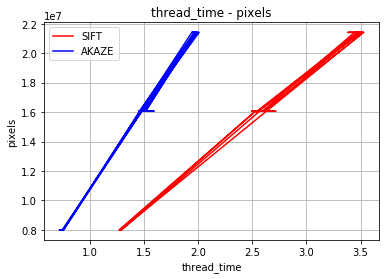

In [128]:
feature_1 = 'thread_time'
feature_2 = 'pixels'
create_curves_for_tabel(feature_1, feature_2, metrices_sift, metrices_akaze)

### Picture - matches_good_ratio
- **red** collor - SIFT 
- **blue** collor - AKAZE

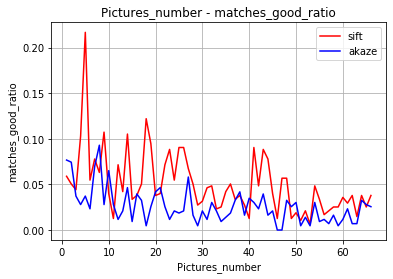

In [129]:
x_label = [x for x in range(1,metrices_sift.shape[0] + 1)]

y_label_swift = metrices_sift['matches_good_ratio']
y_label_akaze = metrices_akaze['matches_good_ratio']

feature_1 = 'Pictures_number'
feature_2 = 'matches_good_ratio'

create_curves_vectors(feature_1, feature_2, x_label, y_label_swift, y_label_akaze)

### Picture - thread_time
- **red** collor - SIFT 
- **blue** collor - AKAZE

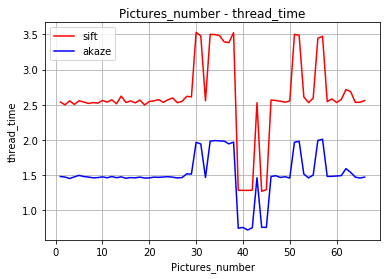

In [130]:
x_label = [x for x in range(1,metrices_sift.shape[0] + 1)]

y_label_swift = metrices_sift['thread_time']
y_label_akaze = metrices_akaze['thread_time']

feature_1 = 'Pictures_number'
feature_2 = 'thread_time'

create_curves_vectors(feature_1, feature_2, x_label, y_label_swift, y_label_akaze)

### Picture - localization_error_l1_mean
- **red** collor - SIFT 
- **blue** collor - AKAZE

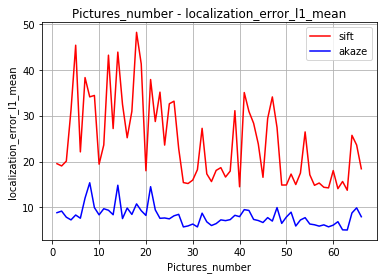

In [131]:
x_label = [x for x in range(1,metrices_sift.shape[0] + 1)]

y_label_swift = metrices_sift['localization_error_l1_mean']
y_label_akaze = metrices_akaze['localization_error_l1_mean']

feature_1 = 'Pictures_number'
feature_2 = 'localization_error_l1_mean'

create_curves_vectors(feature_1, feature_2, x_label, y_label_swift, y_label_akaze)

### Picture - localization_error_l2_mean
- **red** collor - SIFT 
- **blue** collor - AKAZE

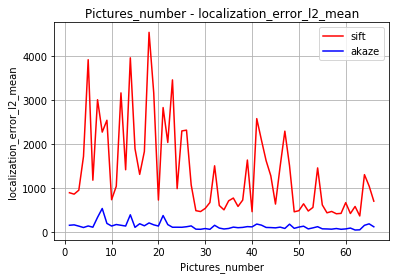

In [132]:
x_label = [x for x in range(1,metrices_sift.shape[0] + 1)]

y_label_swift = metrices_sift['localization_error_l2_mean']
y_label_akaze = metrices_akaze['localization_error_l2_mean']

feature_1 = 'Pictures_number'
feature_2 = 'localization_error_l2_mean'

create_curves_vectors(feature_1, feature_2, x_label, y_label_swift, y_label_akaze)

# Working with metrics FOR SECOND OBJECT

- **red** collor - SIFT 
- **blue** collor - AKAZE

In [133]:
file_name_json_sift = 'lintroller_train_dump/lintroller_sift.json'
file_name_json_akaze = 'lintroller_train_dump/lintroller_akaze.json'
metrices_sift = pd.read_json(file_name_json_sift)
metrices_akaze = pd.read_json(file_name_json_akaze)

metrices_sift = metrices_sift.T
metrices_akaze = metrices_akaze.T

In [134]:
metrices_sift

,ratio,pixels,thread_time,matches_good_ratio,localization_error_l1_mean,localization_error_l2_mean
lintroller_10.jpg,0.75,76800.0,0.031053,0.026172,20.671102,840.212672
lintroller_11.jpg,0.75,76800.0,0.029921,0.021810,20.419175,812.905781
lintroller_12.jpg,0.75,76800.0,0.030318,0.013086,19.118886,686.075782
lintroller_13.jpg,0.75,62458.0,0.026916,0.003272,17.501921,569.075392
lintroller_14.jpg,0.75,53400.0,0.023000,0.030534,24.639130,1111.477171
...,...,...,...,...,...,...
lintroller_78.jpg,0.75,307200.0,0.073299,0.007634,16.549763,527.779491
lintroller_79.jpg,0.75,1228800.0,0.226721,0.004362,13.961658,371.919386
lintroller_8.jpg,0.75,1228800.0,0.256789,0.007634,14.899421,453.012342
lintroller_80.jpg,0.75,921600.0,0.156246,0.017448,20.399958,804.349794


In [135]:
metrices_akaze

,ratio,pixels,thread_time,matches_good_ratio,localization_error_l1_mean,localization_error_l2_mean
lintroller_10.jpg,0.75,76800.0,0.029828,0.009091,8.745455,128.484848
lintroller_11.jpg,0.75,76800.0,0.029992,0.012121,8.430303,129.939394
lintroller_12.jpg,0.75,76800.0,0.029608,0.030303,8.875758,152.293939
lintroller_13.jpg,0.75,62458.0,0.028395,0.003030,8.930303,145.530303
lintroller_14.jpg,0.75,53400.0,0.025063,0.015152,10.827273,200.287879
...,...,...,...,...,...,...
lintroller_78.jpg,0.75,307200.0,0.076636,0.015152,7.654545,107.006061
lintroller_79.jpg,0.75,1228800.0,0.173495,0.006061,6.645455,83.203030
lintroller_8.jpg,0.75,1228800.0,0.174218,0.000000,6.318182,69.675758
lintroller_80.jpg,0.75,921600.0,0.125016,0.012121,8.778788,141.045455


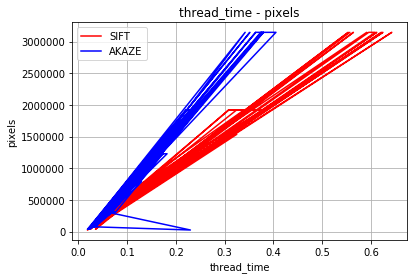

In [136]:
feature_1 = 'thread_time'
feature_2 = 'pixels'
create_curves_for_tabel(feature_1, feature_2, metrices_sift, metrices_akaze)

### Picture - matches_good_ratio
- **red** collor - SIFT 
- **blue** collor - AKAZE

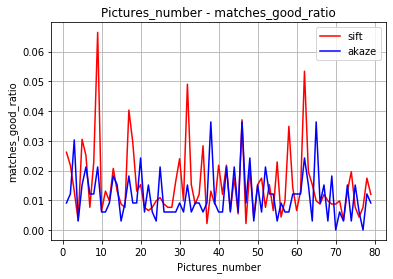

In [137]:
x_label = [x for x in range(1,metrices_sift.shape[0] + 1)]

y_label_swift = metrices_sift['matches_good_ratio']
y_label_akaze = metrices_akaze['matches_good_ratio']

feature_1 = 'Pictures_number'
feature_2 = 'matches_good_ratio'

create_curves_vectors(feature_1, feature_2, x_label, y_label_swift, y_label_akaze)

### Picture - thread_time
- **red** collor - SIFT 
- **blue** collor - AKAZE

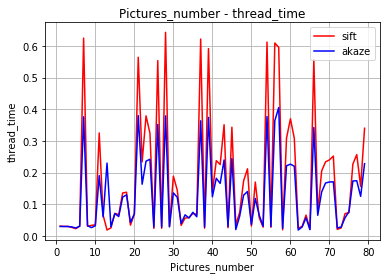

In [138]:
x_label = [x for x in range(1,metrices_sift.shape[0] + 1)]

y_label_swift = metrices_sift['thread_time']
y_label_akaze = metrices_akaze['thread_time']

feature_1 = 'Pictures_number'
feature_2 = 'thread_time'

create_curves_vectors(feature_1, feature_2, x_label, y_label_swift, y_label_akaze)

### Picture - localization_error_l1_mean
- **red** collor - SIFT 
- **blue** collor - AKAZE

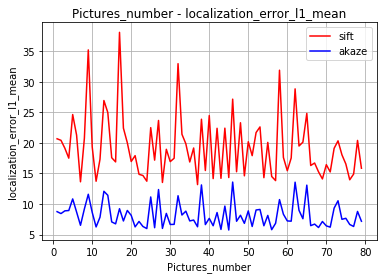

In [139]:
x_label = [x for x in range(1,metrices_sift.shape[0] + 1)]

y_label_swift = metrices_sift['localization_error_l1_mean']
y_label_akaze = metrices_akaze['localization_error_l1_mean']

feature_1 = 'Pictures_number'
feature_2 = 'localization_error_l1_mean'

create_curves_vectors(feature_1, feature_2, x_label, y_label_swift, y_label_akaze)

### Picture - localization_error_l2_mean
- **red** collor - SIFT 
- **blue** collor - AKAZE

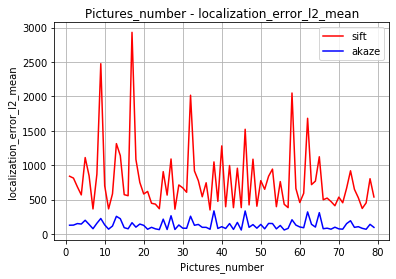

In [140]:
x_label = [x for x in range(1,metrices_sift.shape[0] + 1)]

y_label_swift = metrices_sift['localization_error_l2_mean']
y_label_akaze = metrices_akaze['localization_error_l2_mean']

feature_1 = 'Pictures_number'
feature_2 = 'localization_error_l2_mean'

create_curves_vectors(feature_1, feature_2, x_label, y_label_swift, y_label_akaze)

# TEST sets

In [174]:
lintroller_json_sift = 'test_dump/test_lintroller_sift.json'
lintroller_json_akaze = 'test_dump/test_lintroller_akaze.json'

lintroller_metrices_sift = pd.read_json(lintroller_json_sift)
lintroller_metrices_akaze = pd.read_json(lintroller_json_akaze)

lintroller_metrices_sift = lintroller_metrices_sift.T
lintroller_metrices_akaze = lintroller_metrices_akaze.T

In [175]:
sandglass_json_sift = 'test_dump/test_sandglass_sift.json'
sandglass_json_akaze = 'test_dump/test_sandglass_akaze.json'

sandglass_metrices_sift = pd.read_json(lintroller_json_sift)
sandglass_metrices_akaze = pd.read_json(lintroller_json_akaze)

sandglass_metrices_sift = sandglass_metrices_sift.T
sandglass_metrices_akaze = sandglass_metrices_akaze.T

## Read excel

In [176]:
lintroller_excel_test = 'excel_files/lintroller_test.xlsx'
sandglass_excel_test = 'excel_files/sandglass_test.xlsx'

lintroller_bool = pd.read_excel(lintroller_excel_test)
sandglass_bool = pd.read_excel(sandglass_excel_test)

In [177]:
len(lintroller_metrices_sift)

19

In [178]:
len(lintroller_metrices_akaze)

19

In [179]:
lintroller_bool

,Name,bool
0,lintroller_81,1
1,lintroller_82,1
2,lintroller_83,1
3,lintroller_84,1
4,lintroller_85,0
5,lintroller_86,1
6,lintroller_87,1
7,lintroller_88,1
8,lintroller_89,1
9,lintroller_90,0


In [180]:
sandglass_metrices_sift

,ratio,pixels,thread_time,matches_good_ratio,localization_error_l1_mean,localization_error_l2_mean
lintroller_81.jpg,0.75,307200.0,0.046937,0.039735,28.760709,1624.332313
lintroller_82.jpg,0.75,1228800.0,0.243771,0.011207,15.222127,464.884441
lintroller_83.jpg,0.75,3145728.0,0.621955,0.030056,19.648126,981.243379
lintroller_84.jpg,0.75,76800.0,0.013864,0.030565,25.825429,1368.425068
lintroller_85.jpg,0.75,1228800.0,0.241511,0.012226,15.386412,527.936682
lintroller_86.jpg,0.75,1228800.0,0.228510,0.010698,16.105120,528.785725
lintroller_87.jpg,0.75,1920000.0,0.348337,0.011207,15.739516,502.608228
lintroller_88.jpg,0.75,307200.0,0.061347,0.013245,18.703715,676.733699
lintroller_89.jpg,0.75,1228800.0,0.208960,0.022415,17.364591,670.650215
lintroller_90.jpg,0.75,129600.0,0.023585,0.026999,25.101525,1210.727530


In [181]:
sandglass_bool

,Name,bool
0,sandglass_81,1
1,sandglass_82,1
2,sandglass_83,1
3,sandglass_84,0
4,sandglass_85,1
5,sandglass_86,1
6,sandglass_87,1
7,sandglass_88,0
8,sandglass_89,1
9,sandglass_90,1


In [182]:
lintroller_metrices_sift['bool'] = list(lintroller_bool['bool'])
sandglass_metrices_sift['bool'] = list(sandglass_bool['bool'])

lintroller_metrices_akaze['bool'] = list(lintroller_bool['bool'])
sandglass_metrices_akaze['bool'] = list(sandglass_bool['bool'])

In [197]:
def create_curves_vectors_bool(metrics_sift, metrics_akaze, feature, title, bool_=1):
    
    feature_sift = list(metrics_sift[metrics_sift['bool'] == bool_][feature])
    feature_akaze = list(metrics_akaze[metrics_akaze['bool'] == bool_][feature])
    
    x_label = [x for x in range(len(feature_sift))]
    
    plt.plot(x_label, feature_sift, '-', color='red', label=f'{feature}_sift')
    plt.plot(x_label, feature_akaze, '-', color='blue', label=f'{feature}_akaze')
    
    plt.xlabel('images')
    plt.ylabel(feature)
    plt.grid(True)
    plt.title(f'{title}_{feature}_bool={bool_}')
    
    plt.legend()
    plt.show()
    plt.close()

## Comparing feature values between AKAZE and SIFT by lintroller_test_set

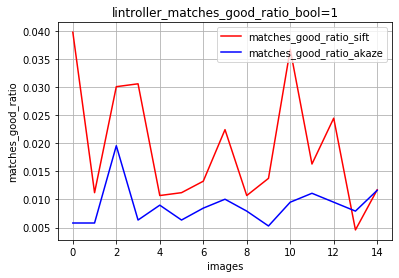

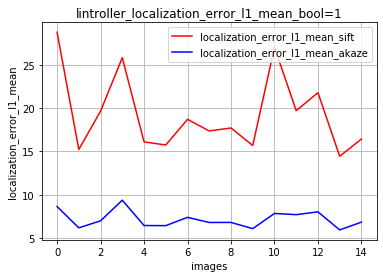

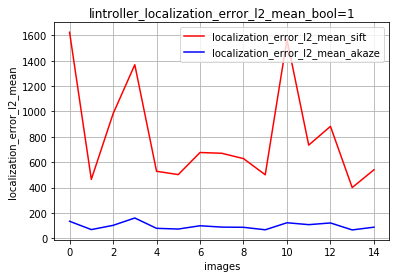

In [198]:
features = ['matches_good_ratio', 'localization_error_l1_mean', 'localization_error_l2_mean']
title = 'lintroller'
bool_my = 1

for feature in features:
    create_curves_vectors_bool(lintroller_metrices_sift, lintroller_metrices_akaze, feature, title, bool_my)

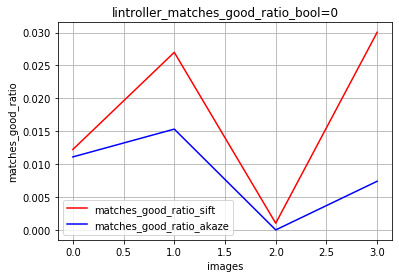

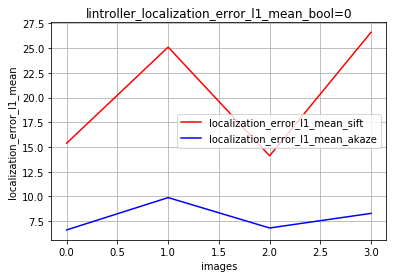

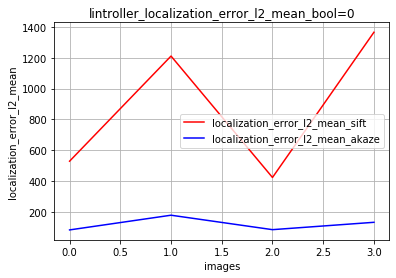

In [200]:
features = ['matches_good_ratio', 'localization_error_l1_mean', 'localization_error_l2_mean']
title = 'lintroller'
bool_my = 0

for feature in features:
    create_curves_vectors_bool(lintroller_metrices_sift, lintroller_metrices_akaze, feature, title, bool_my)

## Comparing feature values between AKAZE and SIFT by sandglass_test_set

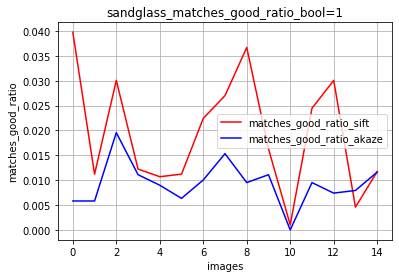

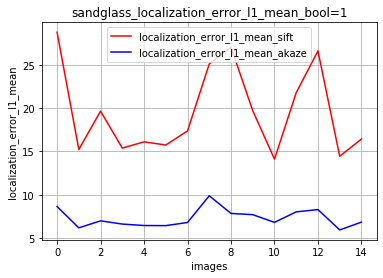

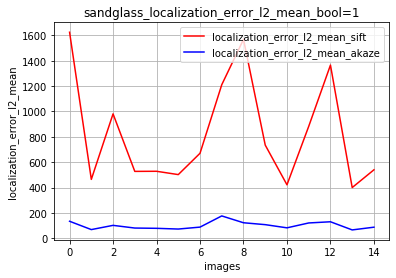

In [201]:
features = ['matches_good_ratio', 'localization_error_l1_mean', 'localization_error_l2_mean']
title = 'sandglass'
bool_my = 1

for feature in features:
    create_curves_vectors_bool(sandglass_metrices_sift, sandglass_metrices_akaze, feature, title, bool_my)

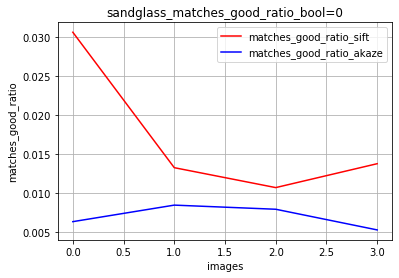

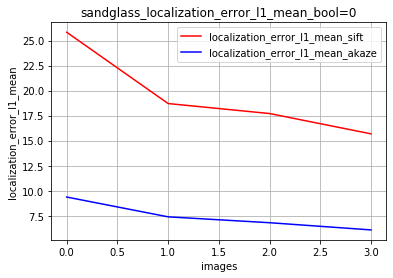

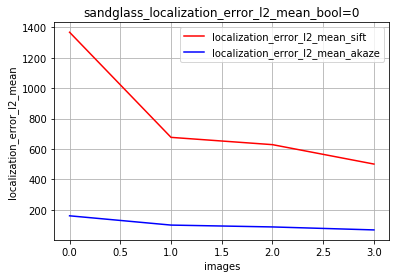

In [202]:
features = ['matches_good_ratio', 'localization_error_l1_mean', 'localization_error_l2_mean']
title = 'sandglass'
bool_my = 0

for feature in features:
    create_curves_vectors_bool(sandglass_metrices_sift, sandglass_metrices_akaze, feature, title, bool_my)

# Concluzions

In [148]:
lintroller_metrices_sift[lintroller_metrices_sift['bool'] == 1]['matches_good_ratio'].to

lintroller_81.jpg    0.039735
lintroller_82.jpg    0.011207
lintroller_83.jpg    0.030056
lintroller_84.jpg    0.030565
lintroller_86.jpg    0.010698
lintroller_87.jpg    0.011207
lintroller_88.jpg    0.013245
lintroller_89.jpg    0.022415
lintroller_91.jpg    0.010698
lintroller_92.jpg    0.013754
lintroller_93.jpg    0.036679
lintroller_94.jpg    0.016302
lintroller_96.jpg    0.024452
lintroller_98.jpg    0.004585
lintroller_99.jpg    0.011717
Name: matches_good_ratio, dtype: float64